In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

# Define the path to your dataset
base_dir = 'Soil types'  # Adjust this to your actual path

# Set up the ImageDataGenerator with validation split
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate training and validation data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

def create_model(optimizer='adam', dropout_rate=0.5, num_filters=32, kernel_size=(3, 3), activation='relu'):
    model = Sequential([
        Conv2D(num_filters, kernel_size, activation=activation, input_shape=(150, 150, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(num_filters * 2, kernel_size, activation=activation),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(num_filters * 4, kernel_size, activation=activation),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation=activation),
        Dropout(dropout_rate),
        Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
    ])
    
    # Choose optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001)
    else:
        opt = SGD(learning_rate=0.01)
        
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter configurations
hyperparams = [
    {'optimizer': 'adam', 'dropout_rate': 0.5, 'num_filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},
    {'optimizer': 'adam', 'dropout_rate': 0.3, 'num_filters': 64, 'kernel_size': (5, 5), 'activation': 'relu'},
    {'optimizer': 'sgd', 'dropout_rate': 0.5, 'num_filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},
    {'optimizer': 'sgd', 'dropout_rate': 0.3, 'num_filters': 64, 'kernel_size': (5, 5), 'activation': 'tanh'},
    {'optimizer': 'adam', 'dropout_rate': 0.5, 'num_filters': 64, 'kernel_size': (3, 3), 'activation': 'relu'},
    {'optimizer': 'adam', 'dropout_rate': 0.5, 'num_filters': 16, 'kernel_size': (5, 5), 'activation': 'relu'},
    {'optimizer': 'sgd', 'dropout_rate': 0.3, 'num_filters': 16, 'kernel_size': (3, 3), 'activation': 'tanh'},
    {'optimizer': 'adam', 'dropout_rate': 0.5, 'num_filters': 128, 'kernel_size': (3, 3), 'activation': 'relu'},
]

accuracies = []
best_model = None
best_accuracy = 0

# Train models
for params in hyperparams:
    model = create_model(**params)
    print(f"Training model with: {params}")
    
    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )
    
    # Evaluate model
    val_loss, val_accuracy = model.evaluate(validation_generator)
    accuracies.append({'params': params, 'accuracy': val_accuracy})
    
    print(f"Validation accuracy: {val_accuracy * 100:.2f}%\n")
    
    # Track the best performing model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model

# Display the results
for result in accuracies:
    print(f"Hyperparameters: {result['params']} => Validation Accuracy: {result['accuracy'] * 100:.2f}%")

# Print metrics for the best model
if best_model:
    print("\nBest Model Summary:")
    best_model.summary()
    print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%\n")

Found 126 images belonging to 5 classes.
Found 30 images belonging to 5 classes.
Training model with: {'optimizer': 'adam', 'dropout_rate': 0.5, 'num_filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'}
Epoch 1/15
4/4 [==============================] - 2s 430ms/step - loss: 1.7319 - accuracy: 0.2143 - val_loss: 1.5794 - val_accuracy: 0.4000
Epoch 2/15
4/4 [==============================] - 1s 344ms/step - loss: 1.6440 - accuracy: 0.1587 - val_loss: 1.5131 - val_accuracy: 0.4000
Epoch 3/15
4/4 [==============================] - 1s 367ms/step - loss: 1.4794 - accuracy: 0.3492 - val_loss: 1.3276 - val_accuracy: 0.3333
Epoch 4/15
4/4 [==============================] - 1s 350ms/step - loss: 1.2971 - accuracy: 0.3333 - val_loss: 1.0888 - val_accuracy: 0.4000
Epoch 5/15
4/4 [==============================] - 1s 353ms/step - loss: 1.1839 - accuracy: 0.4286 - val_loss: 0.9787 - val_accuracy: 0.4667
Epoch 6/15
4/4 [==============================] - 1s 339ms/step - loss: 1.0961 - accuracy: 

1/1 [==============================] - 0s 290ms/step
Classification Report:
                precision    recall  f1-score   support

   Black Soil       0.30      0.43      0.35         7
  Cinder Soil       0.40      0.33      0.36         6
Laterite Soil       0.17      0.17      0.17         6
    Peat Soil       0.00      0.00      0.00         6
  Yellow Soil       0.17      0.20      0.18         5

     accuracy                           0.23        30
    macro avg       0.21      0.23      0.21        30
 weighted avg       0.21      0.23      0.22        30



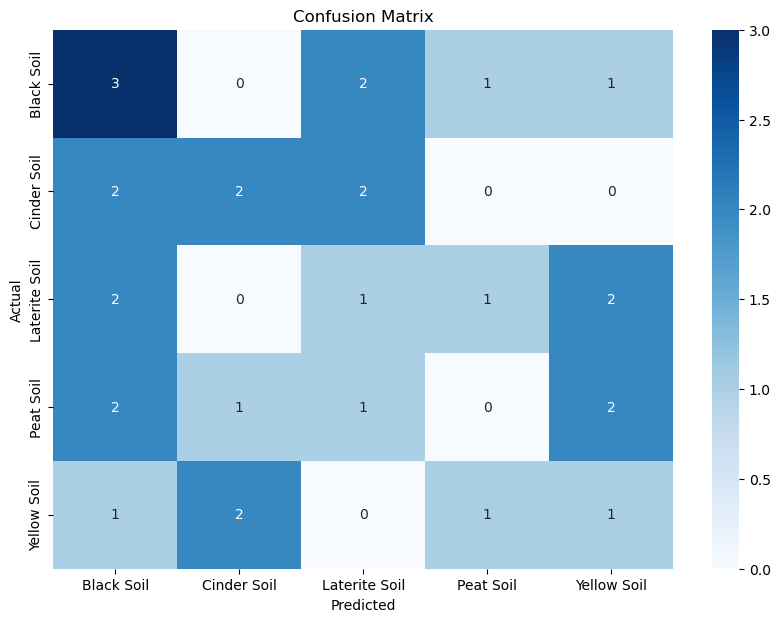

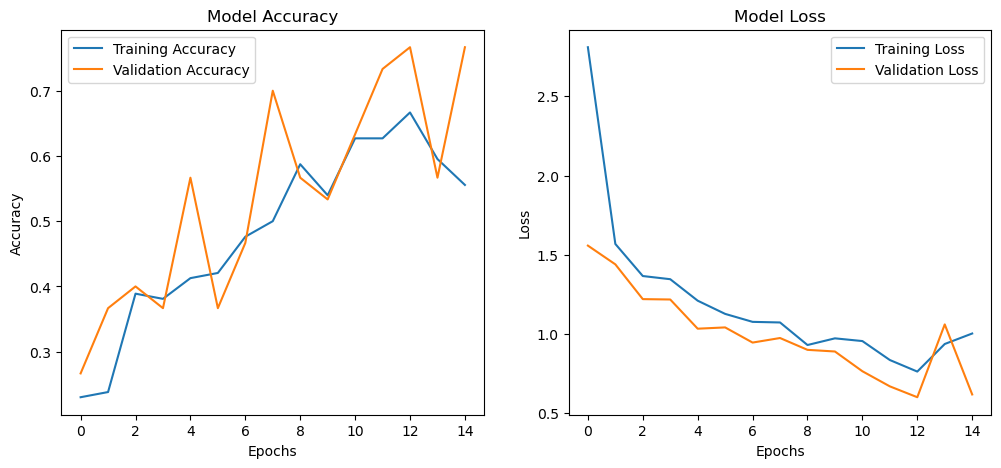

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Assuming 'best_model' is the trained model and 'history' contains training history
# Generate predictions
validation_generator.reset()  # Reset the generator to the first batch
predictions = best_model.predict(validation_generator, steps=len(validation_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes from the generator
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()